# COVID-19 pandemic data analysis

### Obtain data from John Hopkins CSSE repository 

Using @GaelVaroquaux [`covid-dashboard`](https://github.com/covid19-dash/covid-dashboard) helpers

In [1]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "./covid-dashboard/")

In [2]:
import data_input

data = data_input.get_data()

In [3]:
data

type             confirmed                                              \
iso                    AFG    AGO     ALB     AND                  ARE   
country_region Afghanistan Angola Albania Andorra United Arab Emirates   
date                                                                     
2020-01-22               0      0       0       0                    0   
2020-01-23               0      0       0       0                    0   
2020-01-24               0      0       0       0                    0   
2020-01-25               0      0       0       0                    0   
2020-01-26               0      0       0       0                    0   
...                    ...    ...     ...     ...                  ...   
2020-04-12             607     19     446     638                 4123   
2020-04-13             665     19     467     646                 4521   
2020-04-14             714     19     475     659                 4933   
2020-04-15             784     19     494     673                 5365   
2020-04-16             840     19     518     673                 5825   

type                                                                    ...  \
iso                  ARG     ARM                 ATG       AUS     AUT  ...   
country_region Argentina Armenia Antigua and Barbuda Australia Austria  ...   
date                                                                    ...   
2020-01-22             0       0                   0         0       0  ...   
2020-01-23             0       0                   0         0       0  ...   
2020-01-24             0       0                   0         0       0  ...   
2020-01-25             0       0                   0         0       0  ...   
2020-01-26             0       0                   0         4       0  ...   
...                  ...     ...                 ...       ...     ...  ...   
2020-04-12          2142    1013                  21      6315   13945  ...   
2020-04-13          2208    1039                  23      6351   14041  ...   
2020-04-14          2277    1067                  23      6415   14226  ...   
2020-04-15          2443    1111                  23      6440   14336  ...   
2020-04-16          2571    1159                  23      6462   14476  ...   

type             death                           \
iso                URY           USA        UZB   
country_region Uruguay United States Uzbekistan   
date                                              
2020-01-22           0             0          0   
2020-01-23           0             0          0   
2020-01-24           0             0          0   
2020-01-25           0             0          0   
2020-01-26           0             0          0   
...                ...           ...        ...   
2020-04-12           7         22019          4   
2020-04-13           8         23528          4   
2020-04-14           8         25831          4   
2020-04-15           8         28325          4   
2020-04-16           9         32916          4   

type                                                                     \
iso                                         VCT       VEN     VNM   YEM   
country_region Saint Vincent and the Grenadines Venezuela Vietnam Yemen   
date                                                                      
2020-01-22                                    0         0       0     0   
2020-01-23                                    0         0       0     0   
2020-01-24                                    0         0       0     0   
2020-01-25                                    0         0       0     0   
2020-01-26                                    0         0       0     0   
...                                         ...       ...     ...   ...   
2020-04-12                                    0         9       0     0   
2020-04-13                                    0         9       0     0   
2020-04-14                           

### Select countries of interest and retrieve confirmed cases and deaths dataframes

In [4]:
COUNTRIES = ["ESP", "GBR", "DEU", "AUT"]

In [5]:
confirmed = data["confirmed"][COUNTRIES]
dead = data["death"][COUNTRIES]

Text(0.5, 1.0, 'Log-scale plot of number of confirmed cases')

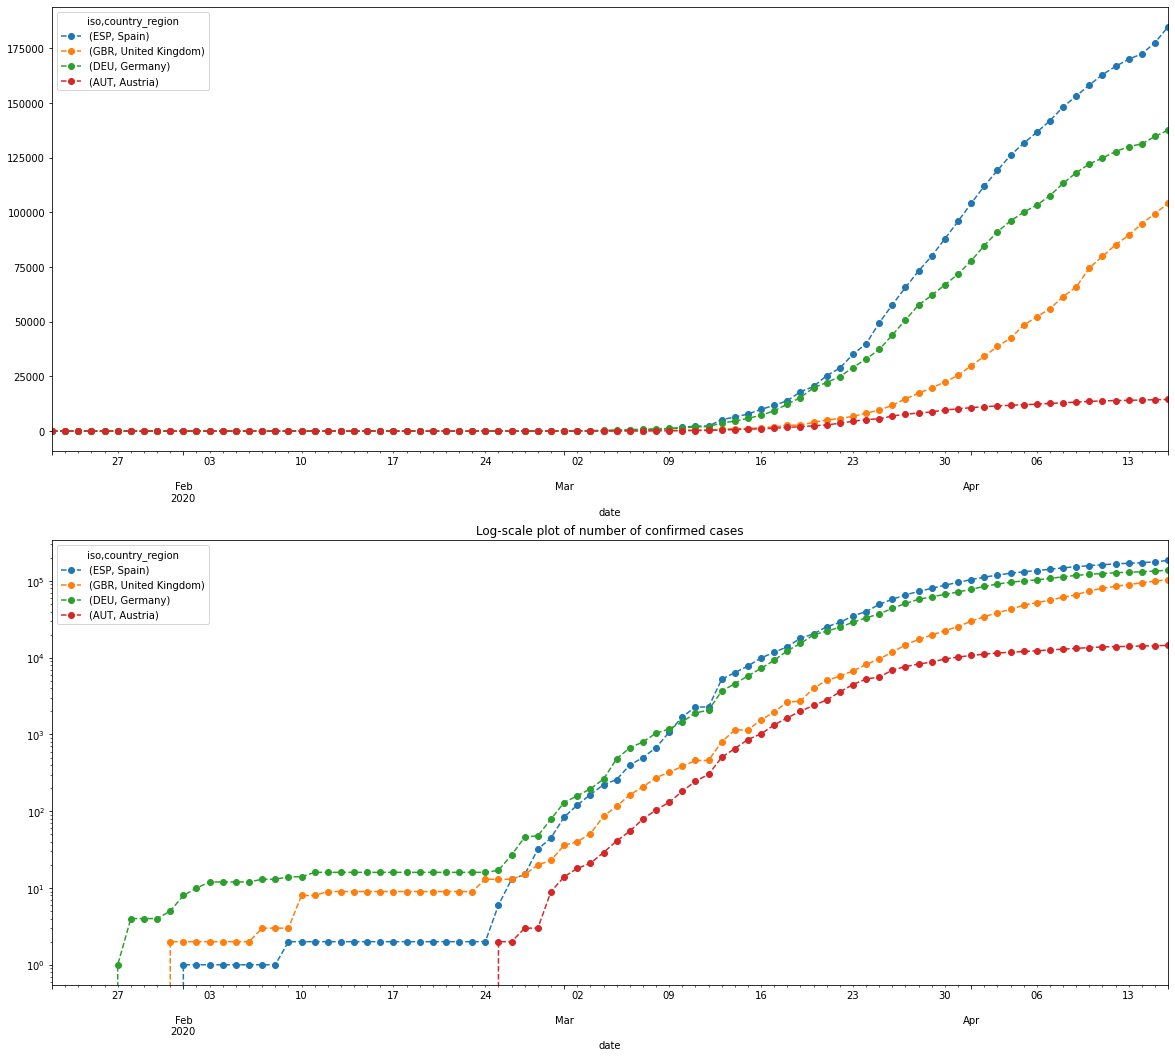

In [6]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
confirmed.plot(ax=top_ax, linestyle="--", marker="o")
confirmed.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale('log')
bottom_ax.set_title("Log-scale plot of number of confirmed cases")

Text(0.5, 1.0, 'Log-scale plot of number of total deaths (daily confirmed)')

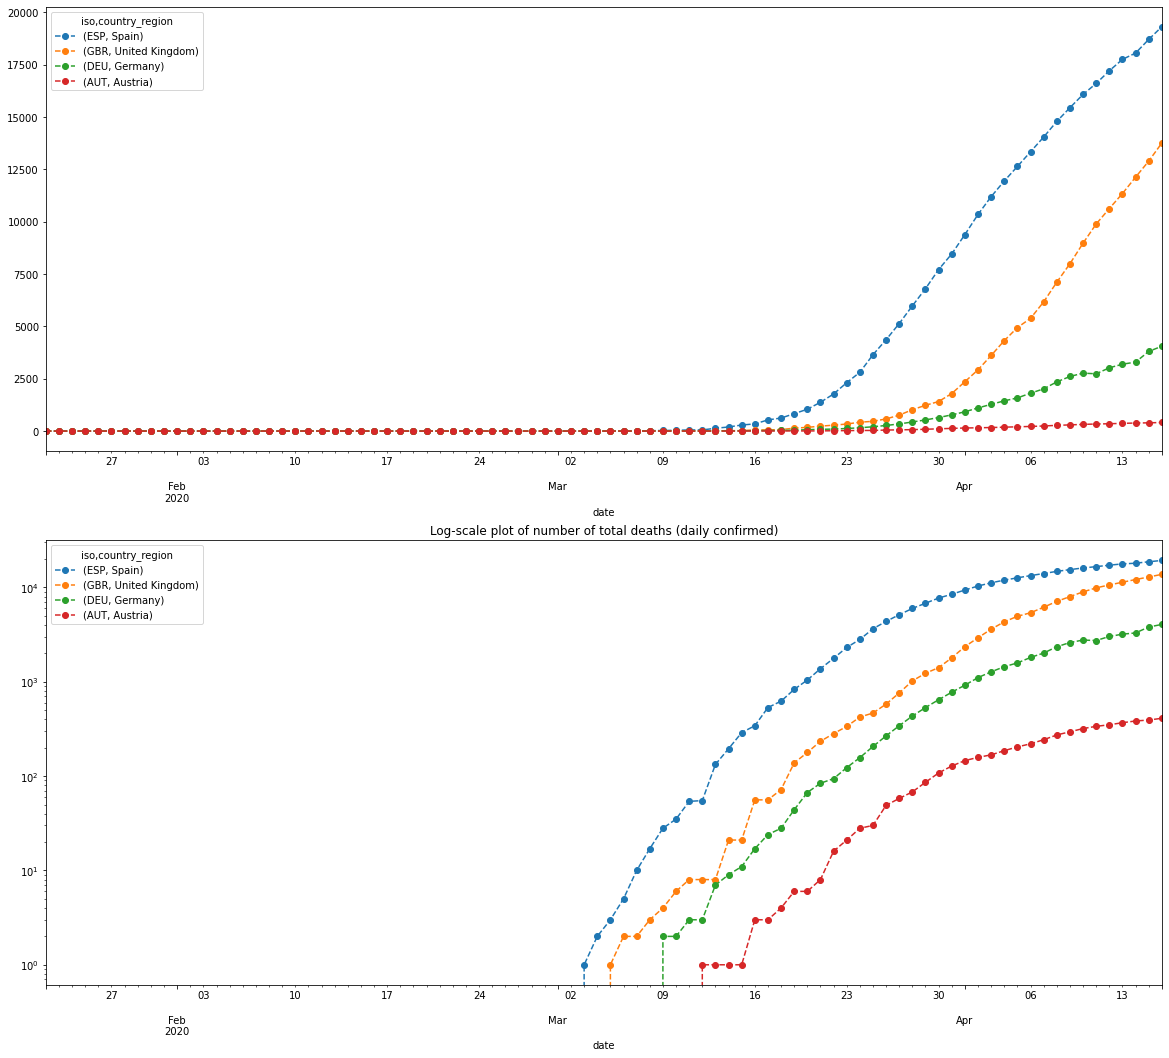

In [7]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
dead.plot(ax=top_ax, linestyle="--", marker="o")
dead.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale('log')
bottom_ax.set_title("Log-scale plot of number of total deaths (daily confirmed)")

In [8]:
# Base Data
confirmed = confirmed[["ESP", "GBR"]]
dead = dead[["ESP", "GBR"]]
growth_rate = confirmed.pct_change()
abs_growth_confirmed = confirmed.diff()
abs_growth_deaths = dead.diff()

In [9]:
# Derived Data for plots
date_lockdown_ES = "2020-03-14" 
date_lockdown_UK = "2020-03-23"
idx_lockdown_ES = confirmed.index.get_loc(date_lockdown_ES)
idx_lockdown_UK = confirmed.index.get_loc(date_lockdown_UK)

confirmed_on_lockdown_ES = abs_growth_confirmed["ESP"].iloc[idx_lockdown_ES]
confirmed_on_lockdown_UK = abs_growth_confirmed["GBR"].iloc[idx_lockdown_UK]

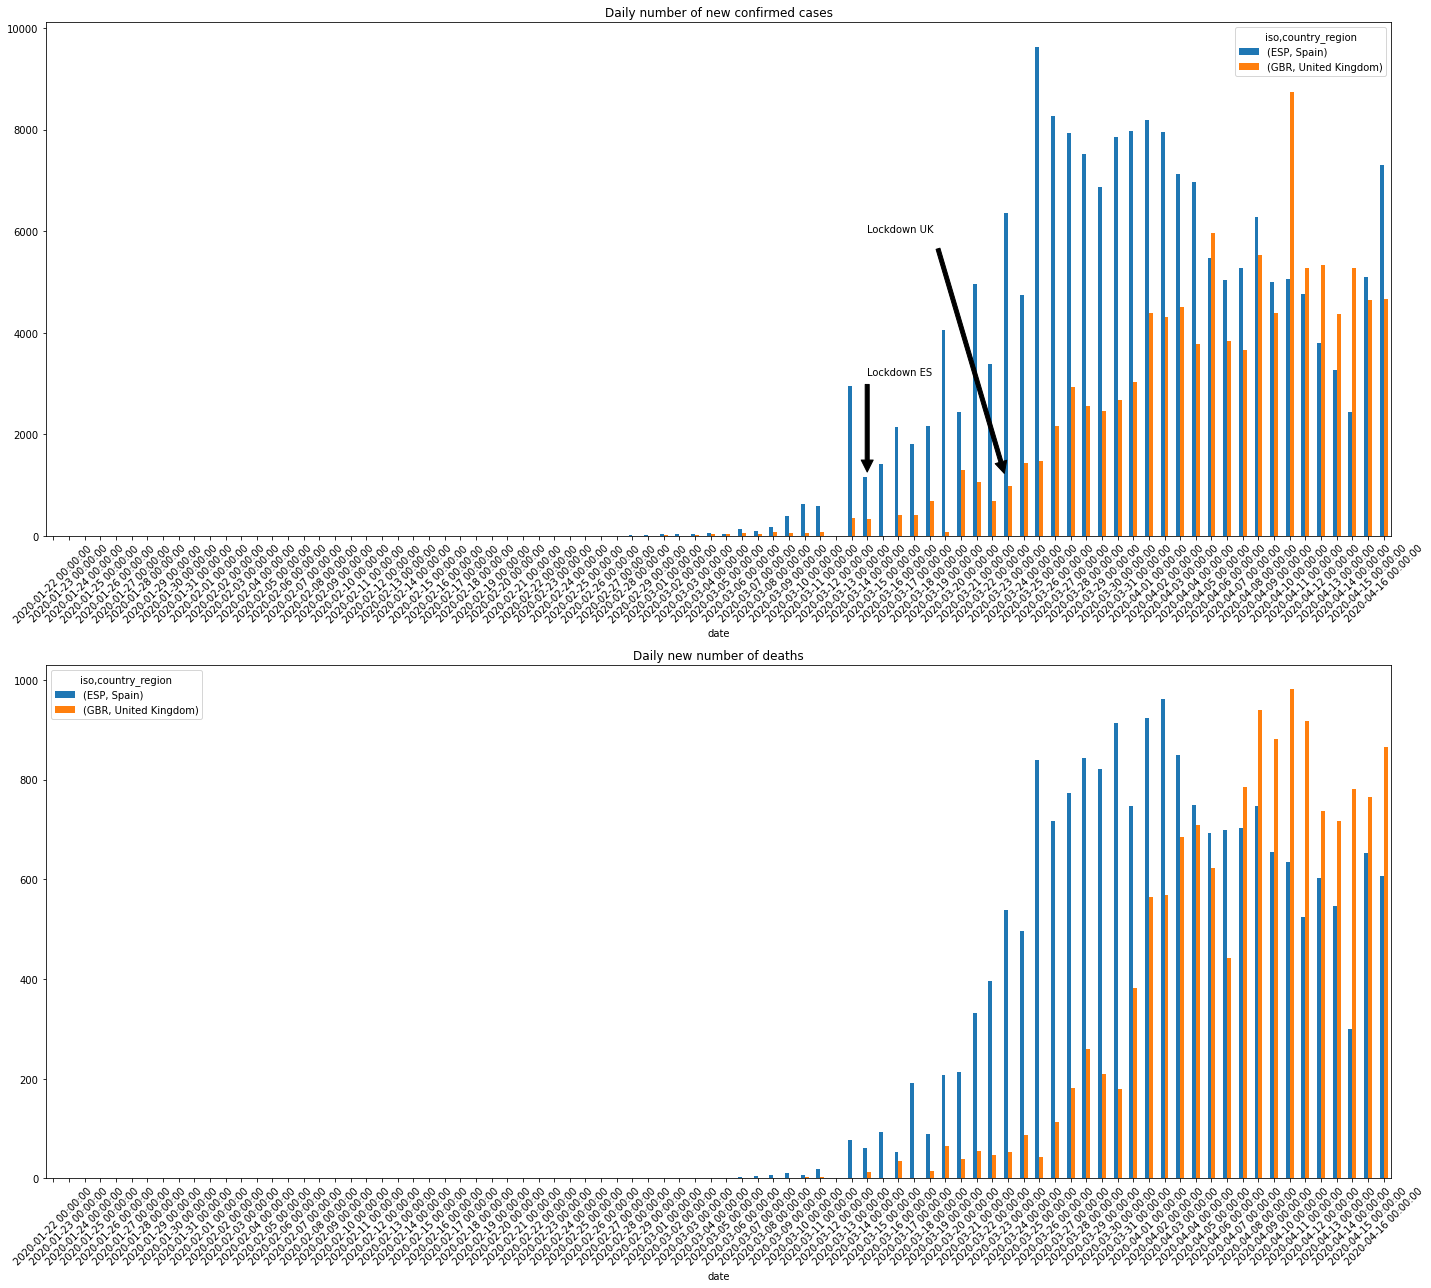

In [10]:
#Plot
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20,18))
abs_growth_confirmed.plot.bar(ax=top_ax, rot=45)
abs_growth_deaths.plot.bar(ax=bottom_ax, rot=45)
# plt.setp(top_ax.get_xticklabels()[::2], visible=False)
# plt.setp(bottom_ax.get_xticklabels()[::2], visible=False)
top_ax.set_title("Daily number of new confirmed cases")
top_ax.annotate("Lockdown ES", xy=(idx_lockdown_ES, confirmed_on_lockdown_ES) ,xytext=(idx_lockdown_ES,confirmed_on_lockdown_ES + 2000), arrowprops=dict(facecolor="black", shrink=0.05))
top_ax.annotate("Lockdown UK", xy=(idx_lockdown_UK, confirmed_on_lockdown_UK) ,xytext=(idx_lockdown_ES,confirmed_on_lockdown_UK + 5000), arrowprops=dict(facecolor="black", shrink=0.05))
bottom_ax.set_title("Daily new number of deaths")
plt.tight_layout()

## Predictive model: a simple approach

In [23]:
import numpy as np

NUM_DAYS = 10  # How many days ago, length of the window
# Build exponential weighting function

def exp_window(length=NUM_DAYS, growth=1.1):
    window = growth ** np.arange(length)
    window = window/window.sum()
    return window

Text(0.5, 1.0, 'Weights over 14 days.')

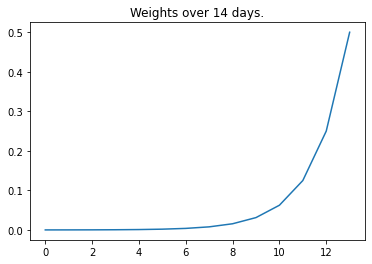

In [24]:
weighted_window = exp_window(length=14, growth=2)
plt.figure()
plt.plot(weighted_window)
plt.title("Weights over 14 days.")

In [39]:
import pandas as pd

import statsmodels.api as sm

data = confirmed.copy()

window = weighted_window

window_size = len(window)

last_fortnight = data.iloc[-window_size:]
last_fortnight

iso,ESP,GBR
country_region,Spain,United Kingdom
date,,
2020-03-24,39885,8164
2020-03-25,49515,9640
2020-03-26,57786,11812
2020-03-27,65719,14745
2020-03-28,73235,17312
2020-03-29,80110,19780
2020-03-30,87956,22453
2020-03-31,95923,25481


In [57]:
log_last_fortnight = np.log(last_fortnight)
log_last_fortnight[log_last_fortnight == -np.inf] = 0

design = pd.DataFrame({"linear": np.arange(window_size),
                       "const": np.ones(window_size)})

growth_rate = pd.DataFrame(data=np.zeros((1, len(data.columns))), columns=data.columns)

In [68]:
predicted_cases = pd.DataFrame()
predicted_cases_lower = pd.DataFrame()
predicted_cases_upper = pd.DataFrame()
prediction_dates = pd.date_range(data.index[-window_size], periods=window_size + 7)

In [70]:
for country in data.columns:
    mode_wls = sm.WLS(log_last_fortnight[country].values, design, weights=window, hasconst=True)
    res_wls = mode_wls.fit()
    growth_rate[country] = np.exp(res_wls.params.linear)
    predicted_cases[country] = np.exp(res_wls.params.const + res_wls.params.linear * np.arange(len(prediction_dates)))
    
    conf_int = res_wls.conf_int(alpha=.25)
    predicted_cases_lower[country] = np.exp(res_wls.params.const + conf_int[0].linear + np.arange(len(prediction_dates)))
    predicted_cases_upper[country] = np.exp(res_wls.params.const +
                conf_int[1].linear * np.arange(len(prediction_dates))
            )
predicted_cases = pd.concat(dict(prediction=predicted_cases, lower_bound=predicted_cases_lower, upper_bound=predicted_cases_upper), axis=1)

In [71]:
predicted_cases["date"] = prediction_dates
predicted_cases = predicted_cases.set_index("date")
if window_size > 10:
    predicted_cases = predicted_cases.iloc[window_size - 10:]

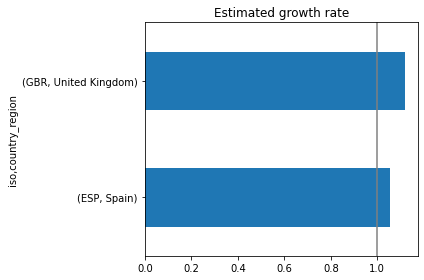

In [73]:
ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title('Estimated growth rate')
ax.axvline(1, color='.5')
plt.tight_layout()

KeyError: 'ESP'

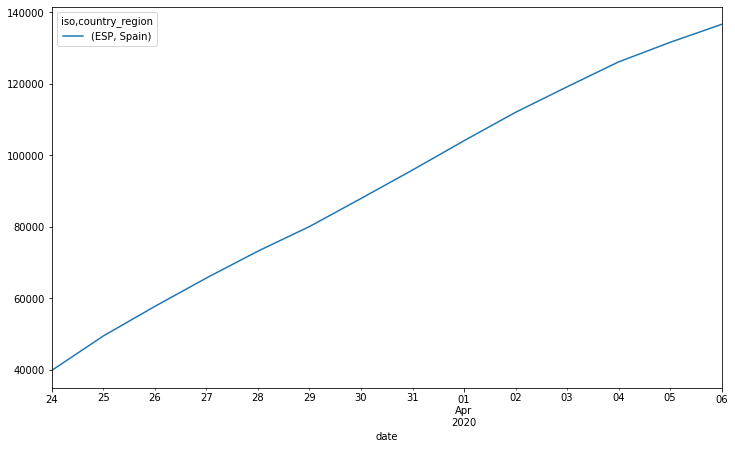

In [85]:
ax = last_fortnight[["ESP"]].plot(figsize=(12, 7))
predicted_cases['prediction']["ESP"].plot(ax=ax, style='--')
predicted_cases['lower_bound']["ESP"].plot(ax=ax, style=':')
predicted_cases['upper_bound']["ESP", "GBR"].plot(ax=ax, style=':')

plt.legend(loc=(.8, -1.3))
ax.set_yscale('log')
ax.set_title('Number of confirmed cases in the last fortnight and prediction')

In [84]:
predicted_cases['prediction'][["ESP"]]


KeyError: "None of [Index(['ESP'], dtype='object')] are in the [columns]"